In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

import os
import cPickle as pickle

In [2]:
plt.rcParams['figure.facecolor'] = 'w'

# Read in Crosssections

for each interaction model there are three files:

- energy grid in [MeV]  ->  need to convert to [GeV] for convention
- non-elasic cross section in [mbarn] for each particle_id
- inclusive cross section in [mbarn] for each channel $p_j \rightarrow p_i$

particle ids are given as $A \times 100 + Z$ and are stored in the first columns of each line

We apply the following unit transformations

- [MeV] -> 1e-3 [GeV]
- [mbarn] -> 1e-27 [cm^2]

In [3]:
%%time
cspath = "./"


# The energy grid is given in MeV, so we convert to GeV
egrid = np.loadtxt(cspath + "peanut_IAS_egrid.dat", dtype = 'float') * 1e-3

# the first columns denote particle ids for the crosssections
pid_nonel = np.loadtxt(cspath + "peanut_IAS_nonel.dat", usecols = (0,), dtype = 'int')
pids_incl = np.loadtxt(cspath + "peanut_IAS_incl_i_j.dat", usecols = (0,1), dtype = 'int')

# the rest of the line denotes the crosssection on the egrid in mbarn, which is converted here to cm^2
crosssec_nonel_raw = np.loadtxt(cspath + "peanut_IAS_nonel.dat", dtype = 'float') * 1e-27
crosssec_incl_raw = np.loadtxt(cspath + "peanut_IAS_incl_i_j.dat", dtype = 'float') * 1e-27

print crosssec_nonel_raw.shape
print crosssec_incl_raw.shape

(405, 149)
(49386, 150)
CPU times: user 6.04 s, sys: 265 ms, total: 6.31 s
Wall time: 6.3 s


## New Version, use dictionary with particle id as key to organise channels

In [4]:
print egrid

[0.001   0.002   0.003   0.004   0.005   0.006   0.007   0.008   0.009
 0.01    0.011   0.012   0.013   0.014   0.015   0.016   0.017   0.018
 0.019   0.02    0.021   0.022   0.023   0.024   0.025   0.026   0.027
 0.028   0.029   0.03    0.031   0.032   0.033   0.034   0.035   0.036
 0.037   0.038   0.039   0.04    0.041   0.042   0.043   0.044   0.045
 0.046   0.047   0.048   0.049   0.05    0.051   0.052   0.053   0.054
 0.055   0.056   0.057   0.058   0.059   0.06    0.061   0.062   0.063
 0.064   0.065   0.066   0.067   0.068   0.069   0.07    0.071   0.072
 0.073   0.074   0.075   0.076   0.077   0.078   0.079   0.08    0.081
 0.082   0.083   0.084   0.085   0.086   0.087   0.088   0.089   0.09
 0.091   0.092   0.093   0.094   0.095   0.096   0.097   0.098   0.099
 0.1     0.11875 0.1375  0.15625 0.175   0.19375 0.2125  0.23125 0.25
 0.26875 0.2875  0.30625 0.325   0.34375 0.3625  0.38125 0.4     0.41875
 0.4375  0.45625 0.475   0.49375 0.5125  0.53125 0.55    0.56875 0.5875
 0.60

We want the cross sections in dictionaries, where each entry corresponds a spline for the particle id

In [5]:
%%time
# Now write the raw data into a dict structure

crosssec_nonel_grid = {}
for idx, line in zip(pid_nonel, crosssec_nonel_raw):
    crosssec_nonel_grid[idx] = line[1:]

crosssec_incl_grid = {}
for (idx1, idx2), line in zip(pids_incl, crosssec_incl_raw):
    crosssec_incl_grid[idx1,idx2] = line[2:]

CPU times: user 113 ms, sys: 35.3 ms, total: 148 ms
Wall time: 116 ms


In [6]:
%%time
from scipy.interpolate import InterpolatedUnivariateSpline

crosssec_nonel = {}
for key in crosssec_nonel_grid:
    crosssec_nonel[key] = InterpolatedUnivariateSpline(egrid, crosssec_nonel_grid[key], k = 1, ext = 'zeros')

crosssec_incl = {}
for key in crosssec_incl_grid:
    crosssec_incl[key] = InterpolatedUnivariateSpline(egrid, crosssec_incl_grid[key], k = 1, ext = 'zeros')

CPU times: user 1.28 s, sys: 90.6 ms, total: 1.37 s
Wall time: 1.36 s


In [7]:
# a dict listing all the channels for the incl. cross section
inclusive_channels = {}
for key in crosssec_incl:
    p_id_in, p_id_out = key
    
    if p_id_in not in inclusive_channels:
        inclusive_channels[p_id_in] = {}
    inclusive_channels[p_id_in][p_id_out] = key

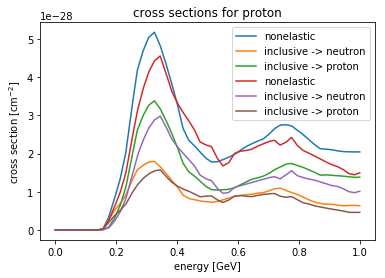

In [8]:
# print nonelastic and inclusive crosssections for proton (pid = 101)
eplot = np.arange(0,1,0.001)

plt.plot(eplot,crosssec_nonel[101](eplot), label = 'nonelastic')
plt.plot(eplot,crosssec_incl[101,100](eplot), label = 'inclusive -> neutron')
plt.plot(eplot,crosssec_incl[101,101](eplot), label = 'inclusive -> proton')

plt.plot(eplot,crosssec_nonel[100](eplot), label = 'nonelastic')
plt.plot(eplot,crosssec_incl[100,100](eplot), label = 'inclusive -> neutron')
plt.plot(eplot,crosssec_incl[100,101](eplot), label = 'inclusive -> proton')

plt.title('cross sections for proton')
plt.xlabel('energy [GeV]')
plt.ylabel('cross section [cm$^{-2}$]')
plt.legend()

#plt.xlim(1e-1,1e3)

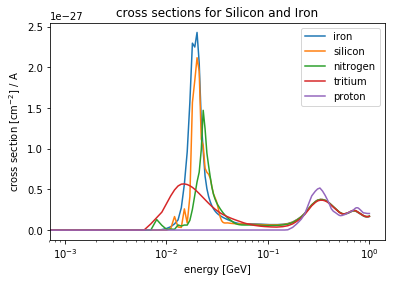

In [9]:
# non elastic cross-section for silicon and iron
# cross section at high energy should scale only with mass number A

plt.figure()
plt.subplot(111)

eplot = np.arange(0,1,0.001)
plt.plot(eplot,crosssec_nonel[5426](eplot)/54., label = 'iron')
plt.semilogx(eplot,crosssec_nonel[2814](eplot)/28., label = 'silicon')
plt.semilogx(eplot,crosssec_nonel[1407](eplot)/14., label = 'nitrogen')
plt.semilogx(eplot,crosssec_nonel[301](eplot)/3., label = 'tritium')
plt.semilogx(eplot,crosssec_nonel[101](eplot)/1., label = 'proton')
#plt.plot(eplot,crosssec_incl[101,100](eplot), label = 'inclusive -> neutron')
#plt.plot(eplot,crosssec_incl[101,101](eplot), label = 'inclusive -> proton')

plt.title('cross sections for Silicon and Iron')
plt.xlabel('energy [GeV]')
plt.ylabel('cross section [cm$^{-2}$] / A')
plt.legend()

plt.show()

# Use SOPHIA Parameterizations at high energies

For the high energy part we want to use a superposition of SOPHIA
these are needed in the same format as other cross sections

There are two ways to achieve this:
 
 * run SOPHIA directly and interpolate on the results
 * extract the parameterization from the SOPHIA code

For now we are using option one

In [10]:
# this files contains the read out data: col.0: energy, col.1: cs_proton, col.2: cs_neutron
s_cs = np.loadtxt('sophia_csec.dat',delimiter=',')

In [11]:
s_egrid, s_pgrid, s_ngrid = np.loadtxt('sophia_csec.dat',delimiter=',', unpack = True)

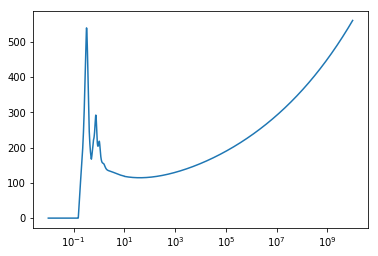

In [12]:
plt.semilogx(s_egrid, s_pgrid)

In [13]:
s_egrid

array([1.00000000e-02, 1.01391839e-02, 1.02803051e-02, ...,
       9.72733778e+09, 9.86272669e+09, 1.00000000e+10])

In [17]:
sys.path.append('/afs/ifh.de/user/j/jheinze/work-jh/git/impy/')
import sophia12

# usage:
# 3rd parameter: 13: proton 14:neutron
sophia12.initial(13)
sophia12.crossection(10.,3,13)

119.13689043353064

In [18]:
len(s_cs[:,0])

2000

In [21]:
%%time
from scipy.interpolate import InterpolatedUnivariateSpline

# vectorize for easy usage
crosssection_sophia_fortran = np.vectorize(sophia12.crossection)

#interpolate the sophia crossection from fortran
egrid = np.logspace(-1,3,400)

sophia12.initial(13)
cgrid = crosssection_sophia_fortran(egrid, 3, 13) * 1e-30 # converted to cm^2
crossec_sophia_proton = InterpolatedUnivariateSpline(egrid, cgrid, k = 1,)# ext = 'zeros')

sophia12.initial(14)
cgrid = crosssection_sophia_fortran(egrid, 3, 14) * 1e-30 # converted to cm^2
crossec_sophia_neutron = InterpolatedUnivariateSpline(egrid, cgrid, k = 1,)# ext = 'zeros')

CPU times: user 1.88 ms, sys: 770 µs, total: 2.65 ms
Wall time: 2.31 ms


In [22]:
myid = 1

In [23]:
type(myid) is int

True

In [24]:
def crossec_sophia_superposition(pid):
    proton_num = pid % 100
    neutron_num = pid / 100 - proton_num
    
    egrid = crossec_sophia_proton.get_knots()
    cs_proton = crossec_sophia_proton.get_coeffs()
    cs_neutron = crossec_sophia_neutron.get_coeffs()

    # the nonelastiv crosssection is just a superposition of the proton/neutron number
    cgrid = proton_num * cs_proton + neutron_num * cs_neutron
    cs_nonel = InterpolatedUnivariateSpline(egrid, cgrid, k = 1,)
    
    # For the inclusive cross section we asume that either a proton or a neutron is ejected
    cgrid = proton_num * cs_proton
    cs_incl_proton = InterpolatedUnivariateSpline(egrid, cgrid, k = 1,)

    cgrid = neutron_num * cs_neutron
    cs_incl_neutron = InterpolatedUnivariateSpline(egrid, cgrid, k = 1,)
    
    return cs_nonel, cs_incl_proton, cs_incl_neutron

In [25]:
%%time 
# do the interpolation for all available isotopes
crosssec_sophia_nonel = {}
crosssec_sophia_incl = {}
for key in crosssec_nonel:
    crosssec_sophia_nonel[key], incl_proton, incl_neutron = crossec_sophia_superposition(key)
    
    crosssec_sophia_incl[key, key - 101] = incl_proton
    crosssec_sophia_incl[key, 101] = incl_proton
    
    crosssec_sophia_incl[key, key - 100] = incl_neutron
    crosssec_sophia_incl[key, 100] = incl_neutron

CPU times: user 54 ms, sys: 24.2 ms, total: 78.3 ms
Wall time: 67.2 ms


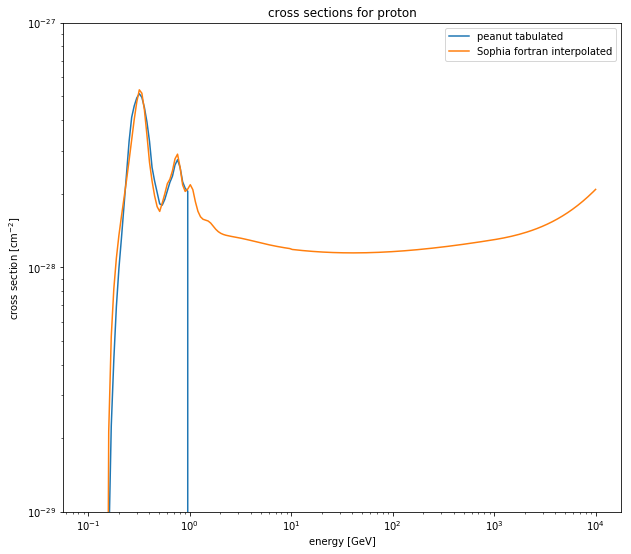

In [26]:
# print nonelastic and inclusive crosssections for proton (pid = 101)
eplot = np.logspace(-1,4,200)

plt.figure(figsize = (10,9))

plt.semilogx(eplot,crosssec_nonel[101](eplot), label = 'peanut tabulated ')
plt.plot(eplot, crosssec_sophia_nonel[101](eplot), label = 'Sophia fortran interpolated')

plt.yscale('log')
plt.title('cross sections for proton')
plt.xlabel('energy [GeV]')
plt.ylabel('cross section [cm$^{-2}$]')
plt.ylim(1e-29,1e-27)
plt.legend()

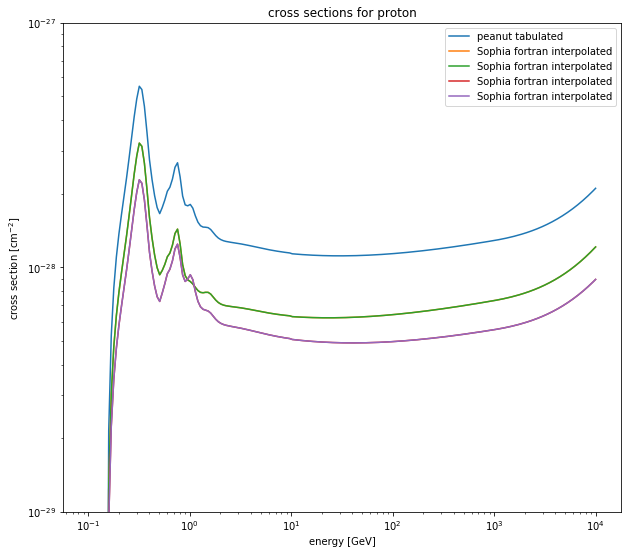

In [27]:
# print nonelastic and inclusive crosssections for proton (pid = 101)
eplot = np.logspace(-1,4,200)

plt.figure(figsize = (10,9))

plt.semilogx(eplot,crosssec_sophia_nonel[5624](eplot)/56, label = 'peanut tabulated ')

plt.plot(eplot, crosssec_sophia_incl[5624,5524](eplot)/56, label = 'Sophia fortran interpolated')
plt.plot(eplot, crosssec_sophia_incl[5624,100](eplot)/56, label = 'Sophia fortran interpolated')

plt.plot(eplot, crosssec_sophia_incl[5624,5523](eplot)/56, label = 'Sophia fortran interpolated')
plt.plot(eplot, crosssec_sophia_incl[5624,101](eplot)/56, label = 'Sophia fortran interpolated')

plt.yscale('log')
plt.title('cross sections for proton')
plt.xlabel('energy [GeV]')
plt.ylabel('cross section [cm$^{-2}$]')
plt.ylim(1e-29,1e-27)
plt.legend()

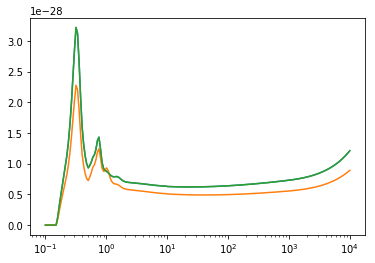

In [28]:
plt.plot(eplot, crosssec_sophia_incl[5624,5524](eplot)/56, label = 'Sophia nonel.')
plt.plot(eplot, crosssec_sophia_incl[5624,101](eplot)/56, label = 'Sophia incl proton eject.')
plt.plot(eplot, crosssec_sophia_incl[5624,100](eplot)/56, label = 'Sophia incl proton eject.')
plt.xscale('log')

### Work in progress: parameterisiations for different contrib. directly from SOPHIA code

In [29]:
def cross_sec_proton_highE(e): # input in GeV
    fac1 = 1 - np.exp(-(e-0.85) / 0.69)
    fac2 = 28.8 * e**-0.34 + 59.3 * e**0.095
    fac1[fac1<0] = 0.
    return fac1 * fac2 * 1e-3 * 1e-27

def cross_sec_proton_highE2(e): # input in GeV
    Q = (e - 0.51)/0.1
    Q[Q < 0.] = 0.
    Q[Q > 1.] = 1.
        
    fac2 = 80.3 * e**-0.34
    return fac2 * 1e-3 * Q * 1e-27

def cross_sec_proton_highE_full(e): # input in GeV
    return cross_sec_proton_highE(e) + cross_sec_proton_highE2(e)

def cross_sec_neutron_highE(e): # input in GeV
    fac1 = 1 - np.exp(-(e-0.85) / 0.69)
    fac2 = 26.0 * e**-0.34 + 59.3 * e**0.095
    fac1[fac1<0] = 0.
    return fac1 * fac2 * 1e-3 * 1e-27

def cross_sec_neutron_highE2(e): # input in GeV
    Q = (e - 0.51)/0.1
    Q[Q < 0.] = 0.
    Q[Q > 1.] = 1.
        
    fac2 = 60.2 * e**-0.34
    return fac2 * 1e-3 * Q * 1e-27

def cross_sec_neutron_highE_full(e): # input in GeV
    return cross_sec_neutron_highE(e) + cross_sec_neutron_highE2(e)

In [30]:
def Pl(eps, eps_thresh, eps_max, alpha):
    A = alpha * eps_max / eps_thresh
    fac1 = ((eps - eps_thresh) / (eps_max - eps_thresh))**(A - alpha)
    fac2 = (eps / eps_max)**-A
    P = fac1 * fac2
    P[eps < eps_thresh] = 0.
    return P

def Qf(eps, eps_thresh, w):
    Q = (eps - eps_thresh) / w
    Q[eps < eps_thresh] = 0.
    Q[eps > eps_thresh + w] = 1.
    return Q

# cross sec
def cross_sec_proton_sophia(eps):
    # fragmentation (dominant at highest energies)
    fac1 = 1 - np.exp(-(eps-0.85) / 0.69)
    fac2 = 28.8 * eps**-0.34 + 59.3 * eps**0.095
    fac1[fac1<0] = 0.
    sigma_frag = fac1 * fac2 * 1e-3 * 1e-27
    
    # residual cross section
    Q = Qf(eps, 0.51, 0.1)
    fac2 = 80.3 * eps**-0.34
    sigma_resid = fac2 * Q * 1e-3 * 1e-27
    
    #direct cross sections
    add1 = 92.7 * Pl(eps,0.152,0.25,2.)
    add2 = 40 * np.exp(-(eps - 0.29)**2 / 0.002)
    add3 = -15 * np.exp(-(eps - 0.37)**2 / 0.002)
    
    sigma_directN = (add1 + add2 + add3) * 1e-3 * 1e-27
    sigma_directD = 37.7 * Pl(eps, 0.4, 0.6, 2.) * 1e-3 * 1e-27
    
    return sigma_frag, sigma_resid, sigma_directN, sigma_directD
    
def cross_sec_neutron_sophia(eps):
    # fragmentation (dominant at highest energies)
    fac1 = 1 - np.exp(-(eps-0.85) / 0.69)
    fac2 = 26.0 * eps**-0.34 + 59.3 * eps**0.095
    fac1[fac1<0] = 0.
    sigma_frag = fac1 * fac2 * 1e-3 * 1e-27
    
    # residual cross section
    Q = Qf(eps, 0.51, 0.1)
    fac2 = 60.2 * eps**-0.34
    sigma_resid = fac2 * Q * 1e-3 * 1e-27
    
    #direct cross sections
    add1 = 92.7 * Pl(eps,0.152,0.25,2.)
    add2 = 40 * np.exp(-(eps - 0.29)**2 / 0.002)
    add3 = -15 * np.exp(-(eps - 0.37)**2 / 0.002)
    
    sigma_directN = (add1 + add2 + add3) * 1e-3 * 1e-27
    sigma_directD = 37.7 * Pl(eps, 0.4, 0.6, 2.) * 1e-3 * 1e-27
        
    return sigma_frag, sigma_resid, sigma_directN, sigma_directD
    

/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


(0.1, 1000.0)

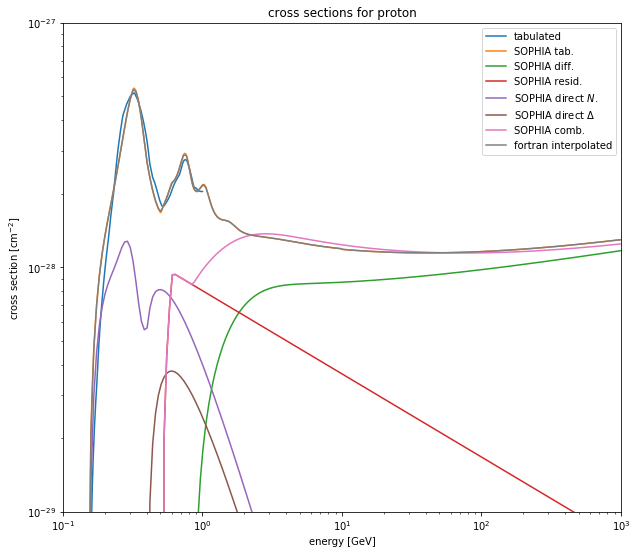

In [32]:
# print nonelastic and inclusive crosssections for proton (pid = 101)
eplot = np.logspace(-1,0,200)
eplot2 = np.logspace(-1,3,200)
cross_sec_proton_sophia

plt.figure(figsize = (10,9))

plt.semilogx(eplot,crosssec_nonel[101](eplot), label = 'tabulated')

e_soph = s_cs[:,0]
c_sec_soph = s_cs[:,1] * 1e-3 * 1e-27
plt.plot(e_soph, c_sec_soph, label = 'SOPHIA tab.')

#plt.plot(eplot2 ,cross_sec_proton_highE(eplot2), label = 'SOPHIA diff.')
#plt.plot(eplot2 ,cross_sec_proton_highE2(eplot2), label = 'SOPHIA resid.')
#plt.plot(eplot2 ,cross_sec_proton_highE_full(eplot2), label = 'SOPHIA comb.')

plt.plot(eplot2 ,cross_sec_proton_sophia(eplot2)[0], label = 'SOPHIA diff.')
plt.plot(eplot2 ,cross_sec_proton_sophia(eplot2)[1], label = 'SOPHIA resid.')
plt.plot(eplot2 ,cross_sec_proton_sophia(eplot2)[2] + cross_sec_proton_sophia(eplot2)[3], label = 'SOPHIA direct $N$.')
plt.plot(eplot2 ,cross_sec_proton_sophia(eplot2)[3], label = 'SOPHIA direct $\Delta$')
plt.plot(eplot2 ,cross_sec_proton_sophia(eplot2)[0] + cross_sec_proton_sophia(eplot2)[1], label = 'SOPHIA comb.')

plt.plot(eplot2, crossec_sophia_proton(eplot2), label = 'fortran interpolated')

#sophia.initial(13)
#plt.plot(eplot2 ,crosssection_sophia_fortran(eplot2,3,13)*1e-30, label = 'SOPHIA Fortran', linestyle = 'dashed')

plt.yscale('log')
plt.ylim(1e-29,1e-27)
plt.title('cross sections for proton')
plt.xlabel('energy [GeV]')
plt.ylabel('cross section [cm$^{-2}$]')
plt.legend()


plt.xlim(1e-1,1e3)

# Combined crossection

As in Neucosma, we will approximate the cross section above 200 MeV by a superposition of the sophia model
and only use the photodisintegration crossection below that energy

In [33]:
def get_combined_cross_section(csec1, csec2, e_trans):
    e1 = csec1.get_knots()
    c1 = csec1.get_coeffs()

    e2 = csec2.get_knots()
    c2 = csec2.get_coeffs()
    
    egrid = np.concatenate([e1[e1 < e_trans], e2[e2 > e_trans]])
    cgrid = np.concatenate([c1[e1 < e_trans], c2[e2 > e_trans]])
    
    return InterpolatedUnivariateSpline(egrid, cgrid, k = 1,)

In [34]:
%%timeit
cs_comb = get_combined_cross_section(crosssec_nonel[402], crosssec_sophia_nonel[402], 0.2)

The slowest run took 14.11 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 40.8 µs per loop


In [35]:
%%time
crosssec_combined_nonel = {}
for key in crosssec_nonel:
    crosssec_combined_nonel[key] = get_combined_cross_section(crosssec_nonel[key], crosssec_sophia_nonel[key], 0.2)

CPU times: user 15.7 ms, sys: 17.9 ms, total: 33.5 ms
Wall time: 25 ms


In [36]:
%%time
crosssec_combined_incl = {}
for key in crosssec_incl:
    if key in crosssec_sophia_incl:
        crosssec_combined_incl[key] = get_combined_cross_section(crosssec_incl[key], crosssec_sophia_incl[key], 0.2)
    else:
        crosssec_combined_incl[key] = crosssec_incl[key]

CPU times: user 121 ms, sys: 26 ms, total: 147 ms
Wall time: 136 ms


(0.01, 1000.0)

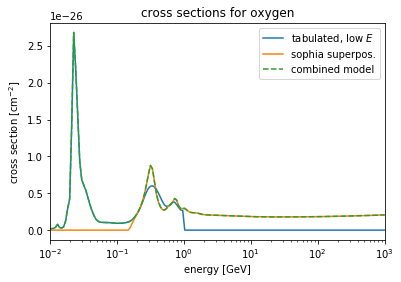

In [37]:
# print nonelastic and inclusive crosssections for oxygen (pid = 1608)
eplot = np.logspace(-3,3,200)

plt.semilogx(eplot,crosssec_nonel[1608](eplot), label = 'tabulated, low $E$')
plt.semilogx(eplot,crosssec_sophia_nonel[1608](eplot), label = 'sophia superpos.')
plt.semilogx(eplot,crosssec_combined_nonel[1608](eplot), label = 'combined model', linestyle= 'dashed')

plt.title('cross sections for oxygen')
plt.xlabel('energy [GeV]')
plt.ylabel('cross section [cm$^{-2}$]')
plt.legend()


plt.xlim(1e-2,1e3)

(0.01, 1000.0)

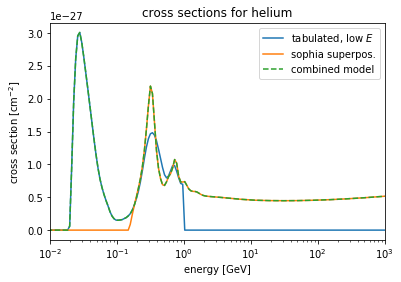

In [38]:
# print nonelastic and inclusive crosssections for helium (pid = 402)
eplot = np.logspace(-3,3,200)

plt.semilogx(eplot,crosssec_nonel[402](eplot), label = 'tabulated, low $E$')
plt.semilogx(eplot,crosssec_sophia_nonel[402](eplot), label = 'sophia superpos.')
plt.semilogx(eplot,crosssec_combined_nonel[402](eplot), label = 'combined model', linestyle= 'dashed')

plt.title('cross sections for helium')
plt.xlabel('energy [GeV]')
plt.ylabel('cross section [cm$^{-2}$]')
plt.legend()


plt.xlim(1e-2,1e3)

(0.01, 1000.0)

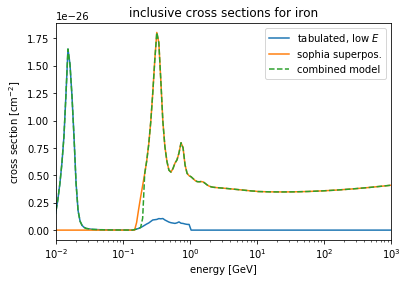

In [39]:
# print inclusive and inclusive crosssections for helium (pid = 402)
eplot = np.logspace(-3,3,200)

plt.semilogx(eplot,crosssec_incl[5624,5524](eplot), label = 'tabulated, low $E$')
plt.semilogx(eplot,crosssec_sophia_incl[5624,5524](eplot), label = 'sophia superpos.')
plt.semilogx(eplot,crosssec_combined_incl[5624,5524](eplot), label = 'combined model', linestyle= 'dashed')

plt.title('inclusive cross sections for iron')
plt.xlabel('energy [GeV]')
plt.ylabel('cross section [cm$^{-2}$]')
plt.legend()


plt.xlim(1e-2,1e3)

# Precompute response function

The response function $f_j(y)$ is defined as:
$$
f_j(y) = \frac{1}{2 y^2} \int_{0}^{2 y} \! \epsilon_r \, \sigma_j(\epsilon_r) \, \mathrm{d}\epsilon_r
$$

It can be precomputed here and stored for each particle in the same structure as $\sigma_i$

$\sigma$ is in [cm$^{2}$] and $\epsilon_r$ and $y$ in [GeV] so $f_j$ will be in [cm$^{2}$]

In [40]:
def calc_response_function(y, cross_section):
    from scipy import integrate

    integrand = lambda e: e * cross_section(e)
    integral, error = integrate.quad(integrand,0., 2*y, epsrel=0.01) 
    
    return integral / (2 * y**2)

In [41]:
#%%timeit
calc_response_function(0.05, crosssec_combined_nonel[402])

6.9278904487457505e-28

In [42]:
def calc_response_function_fast(y, cross_section):
    from scipy import integrate

    e = cross_section.get_knots()
    c = cross_section.get_coeffs()
    
    egrid = e[e < 2*y]
    cgrid = c[e < 2*y]

    integral = integrate.trapz(egrid * cgrid, x = egrid)

    return integral / (2 * y**2)

In [43]:
#%%timeit
calc_response_function_fast(0.05, crosssec_combined_nonel[402])

6.889687632e-28

In [44]:
def calc_response_function_fast2(y, cross_section):
    from scipy import integrate

    e = cross_section.get_knots()
    c = cross_section.get_coeffs()
    
    egrid = e[e < 2*y]
    cgrid = c[e < 2*y]
    
    integral = integrate.simps(egrid * cgrid, egrid)
    
    return integral / (2 * y**2)

In [45]:
#%%timeit
calc_response_function_fast2(0.05, crosssec_combined_nonel[402])

6.888248101333333e-28

In [46]:
def calc_response_function_cum(cross_section):
    from scipy import integrate

    e = cross_section.get_knots()
    c = cross_section.get_coeffs()
    y = e / 2

    integral = integrate.cumtrapz(e * c, x = e)

    res = integral / (2 * y[1:]**2)
    return InterpolatedUnivariateSpline(y[1:], res, k = 1,)

In [47]:
%%timeit
calc_response_function_cum(crosssec_combined_nonel[402])

The slowest run took 10.21 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 55.2 µs per loop


In [48]:
%%time

from scipy.interpolate import interp1d

get_response_func = np.vectorize(calc_response_function)

egrid_response = np.logspace(-3,2,300)

response_func_nonel = {}
for key in crosssec_combined_nonel:
    result = get_response_func(egrid_response, lambda x: crosssec_combined_nonel[key](x))
    response_func_nonel[key] = InterpolatedUnivariateSpline(egrid_response, result, k = 1)

CPU times: user 38.4 s, sys: 482 ms, total: 38.8 s
Wall time: 37.9 s


In [49]:
%%time 

response_func_nonel_fast = {}
for key, value in crosssec_combined_nonel.items():
    response_func_nonel_fast[key] = calc_response_function_cum(value)

CPU times: user 36.7 ms, sys: 11.3 ms, total: 48 ms
Wall time: 33.1 ms


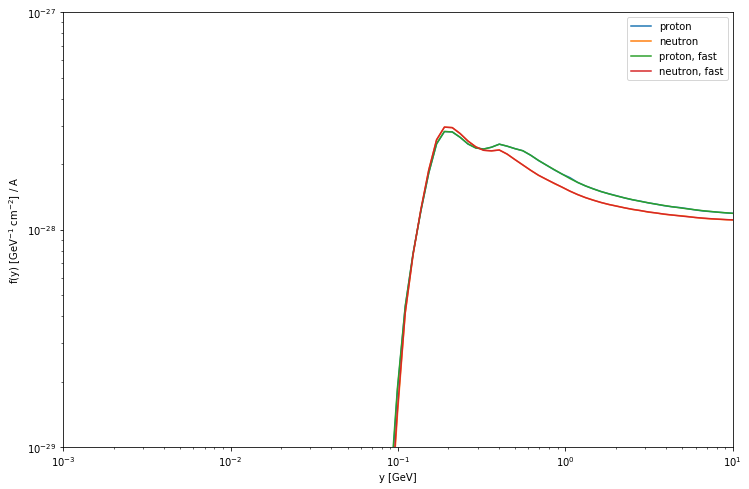

In [50]:
egrid_response = np.logspace(-4,10,300)

plt.figure(figsize=(12,8))

plt.semilogx(egrid_response,response_func_nonel[101](egrid_response), label = 'proton')
plt.semilogx(egrid_response,response_func_nonel[100](egrid_response), label = 'neutron')

plt.semilogx(egrid_response ,response_func_nonel_fast[101](egrid_response), label = 'proton, fast')
plt.semilogx(egrid_response ,response_func_nonel_fast[100](egrid_response), label = 'neutron, fast')

plt.xlabel('y [GeV]')
plt.ylabel('f(y) [GeV$^{-1}$ cm$^{-2}$] / A')
plt.yscale('log')
plt.xlim(1e-3,1e1)
plt.ylim(1e-29,1e-27)
plt.legend()

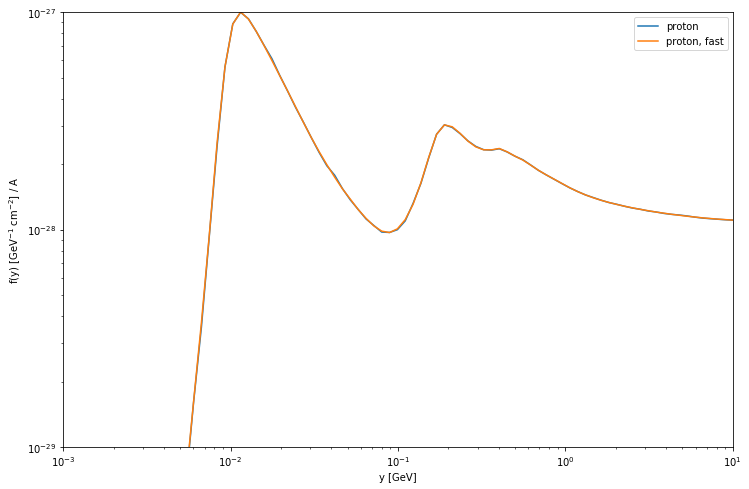

In [51]:
egrid_response = np.logspace(-4,10,300)

plt.figure(figsize=(12,8))

plt.semilogx(egrid_response,response_func_nonel[5426](egrid_response)/56, label = 'proton')

plt.semilogx(egrid_response ,response_func_nonel_fast[5426](egrid_response)/56, label = 'proton, fast')


plt.xlabel('y [GeV]')
plt.ylabel('f(y) [GeV$^{-1}$ cm$^{-2}$] / A')
plt.yscale('log')
plt.xlim(1e-3,1e1)
plt.ylim(1e-29,1e-27)
plt.legend()

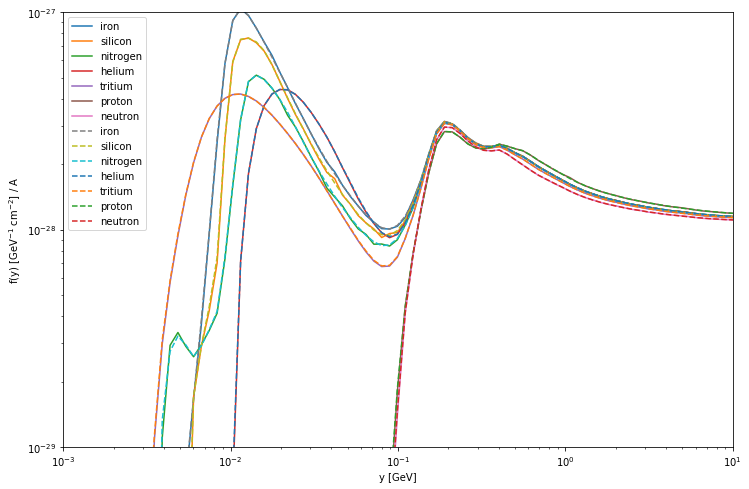

In [52]:
egrid_response = np.logspace(-4,10,300)

plt.figure(figsize=(12,8))

plt.semilogx(egrid_response,response_func_nonel[5426](egrid_response)/54, label = 'iron')
plt.semilogx(egrid_response,response_func_nonel[2814](egrid_response)/28, label = 'silicon')
plt.semilogx(egrid_response,response_func_nonel[1407](egrid_response)/14, label = 'nitrogen')
plt.semilogx(egrid_response,response_func_nonel[402](egrid_response)/4, label = 'helium')
plt.semilogx(egrid_response,response_func_nonel[301](egrid_response)/3, label = 'tritium')
plt.semilogx(egrid_response,response_func_nonel[101](egrid_response)/1, label = 'proton')
plt.semilogx(egrid_response,response_func_nonel[100](egrid_response)/1, label = 'neutron')

plt.semilogx(egrid_response,response_func_nonel_fast[5426](egrid_response)/54, label = 'iron', linestyle = 'dashed')
plt.semilogx(egrid_response,response_func_nonel_fast[2814](egrid_response)/28, label = 'silicon', linestyle = 'dashed')
plt.semilogx(egrid_response,response_func_nonel_fast[1407](egrid_response)/14, label = 'nitrogen', linestyle = 'dashed')
plt.semilogx(egrid_response,response_func_nonel_fast[402](egrid_response)/4, label = 'helium', linestyle = 'dashed')
plt.semilogx(egrid_response,response_func_nonel_fast[301](egrid_response)/3, label = 'tritium', linestyle = 'dashed')
plt.semilogx(egrid_response,response_func_nonel_fast[101](egrid_response)/1, label = 'proton', linestyle = 'dashed')
plt.semilogx(egrid_response,response_func_nonel_fast[100](egrid_response)/1, label = 'neutron', linestyle = 'dashed')

plt.xlabel('y [GeV]')
plt.ylabel('f(y) [GeV$^{-1}$ cm$^{-2}$] / A')
plt.yscale('log')
plt.xlim(1e-3,1e1)
plt.ylim(1e-29,1e-27)
plt.legend()

# Calculating the interaction rates

The interaction rates are given in terms of the response function as:
$$
\Gamma_j(E_j, z) = \int n_\gamma(\epsilon, z) \cdot f_j(y) \, \mathrm{d}\epsilon
$$
where $y = (E_j \cdot \epsilon) / m_A$

In [54]:
class EnergyGrid(object):
    def __init__(self, lower, upper, bins_dec):
        self.bins = np.logspace(lower,upper,(upper-lower) * bins_dec + 1)
        self.grid = 0.5*(self.bins[1:] + self.bins[:-1])
        self.widths = self.bins[1:] - self.bins[:-1]
        
e_cosmicray = EnergyGrid(5,13,10)
e_photons = EnergyGrid(-20,-5,200)

## Photonfields - CMB and combined

In [55]:
from prince import photonfields
CMB = photonfields.CMBPhotonSpectrum()
CIB = photonfields.CIBFranceschini2D()
combined = photonfields.CombinedPhotonField([photonfields.CMBPhotonSpectrum,photonfields.CIBFranceschini2D])

/afs/ifh.de/group/that/work-jh/packages/PriNCe/prince/photonfields.py:122: RuntimeWarning: overflow encountered in exp
  nlocal = pref * Ered**2 / (np.exp(Ered / E_CMB) - 1.0)


(0.0001, 10000.0)

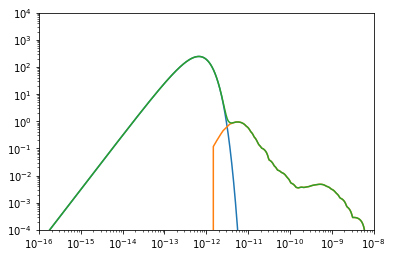

In [56]:
plt.loglog(e_photons.grid, e_photons.grid * CMB.get_photon_density(e_photons.grid, 0.))
plt.loglog(e_photons.grid, e_photons.grid * CIB.get_photon_density(e_photons.grid, 0.))
plt.loglog(e_photons.grid, e_photons.grid * combined.get_photon_density(e_photons.grid, 0.))
plt.xlim([1e-16,1e-8])
plt.ylim([1e-4,1e4])

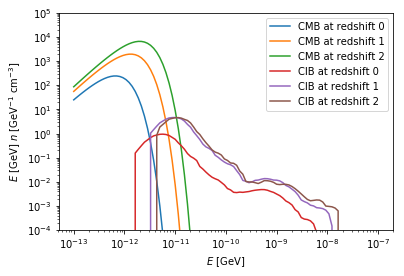

In [57]:
e = np.logspace(-13,-7,100)

plt.loglog(e, e * CMB.get_photon_density(e,0.), label = 'CMB at redshift 0')
plt.loglog(e, e * CMB.get_photon_density(e,1.), label = 'CMB at redshift 1')
plt.loglog(e, e * CMB.get_photon_density(e,2.), label = 'CMB at redshift 2')

plt.loglog(e, e * CIB.get_photon_density(e,0.), label = 'CIB at redshift 0')
plt.loglog(e, e * CIB.get_photon_density(e,1.), label = 'CIB at redshift 1')
plt.loglog(e, e * CIB.get_photon_density(e,2.), label = 'CIB at redshift 2')

plt.xlabel('$E$ [GeV]')
plt.ylabel('$E$ [GeV] $n$ [GeV$^{-1}$ cm$^{-3}$]')
plt.ylim([1e-4,1e5])
plt.legend()

## Exact method by solving the integral

The interaction rates are given in terms of the response function as:
$$
\Gamma_j(E_j, z) = \int \! n_\gamma(\epsilon, z) \cdot f_j(y) \, \mathrm{d}\epsilon
$$
where $y = (E_j\cdot \epsilon) \, / \, m_A$

In [58]:
def get_y(E, eps, particle_id):
    m_proton = 0.9382720813 # GeV
    A = particle_id / 100
    return E*eps /(A * m_proton)

In [59]:
def get_interaction_rate(photonfield, proj_id, E, z):
    from scipy import integrate

    def integrand(e):
        e = 10**e
        y = get_y(E, e, proj_id)
        return photonfield.get_photon_density(e,z) * response_func_nonel[proj_id](y)*e*np.log(10)
    
    integral, error = integrate.quad(integrand, -20, -8, epsrel=1e-3)
    return integral

(1e-35, 3.5850124427083605e+24)

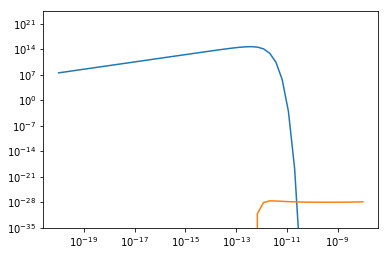

In [60]:
evec = np.logspace(-20,-8)
plt.loglog(evec, CMB.get_photon_density(evec,0.))
plt.loglog(evec, response_func_nonel[101](get_y(1e11, evec, 101)))
plt.ylim(1e-35,)

CPU times: user 622 ms, sys: 39.5 ms, total: 661 ms
Wall time: 629 ms


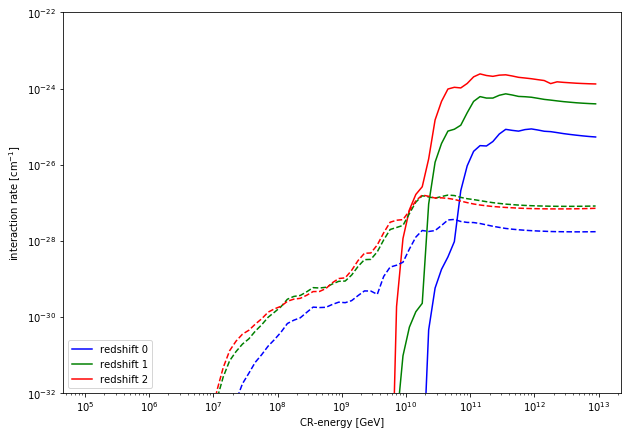

In [61]:
%%time
plt.figure(figsize = [10,7])

func = np.vectorize(get_interaction_rate)
eplot = e_cosmicray.grid

plt.loglog(eplot, func(CMB, 101, eplot, 0.), label = 'redshift 0', color = 'blue')
plt.loglog(eplot, func(CMB, 101, eplot, 1.), label = 'redshift 1', color = 'green')
plt.loglog(eplot, func(CMB, 101, eplot, 2.), label = 'redshift 2', color = 'red')

plt.loglog(eplot, func(CIB, 101, eplot, 0.), linestyle = 'dashed', color = 'blue')
plt.loglog(eplot, func(CIB, 101, eplot, 1.), linestyle = 'dashed', color = 'green')
plt.loglog(eplot, func(CIB, 101, eplot, 2.), linestyle = 'dashed', color = 'red')

plt.legend(loc = 'lower left')
plt.xlabel('CR-energy [GeV]')
plt.ylabel('interaction rate [cm$^{-1}$]')

plt.ylim([1e-32,1e-22])

## Effective Matrix Approach for the integral

In [62]:
def get_y(E, eps, particle_id):
    m_proton = 0.9382720813 # GeV
    A = particle_id / 100
    return E*eps /(A * m_proton)

In [63]:
def get_interaction_rate_fast(photonfield, proj_id, E, z, ephoton):
    x,y = np.meshgrid(ephoton.grid, E)
    
    M = get_y(x, y, proj_id)
    M = response_func_nonel[proj_id](M)

    photon_vector = photonfield.get_photon_density(ephoton.grid, z)
    M = M * photon_vector * ephoton.widths

    int_rate = np.sum(M,axis = 1)
    return int_rate

In [64]:
def get_interaction_rate_fast(photonfield, proj_id, E, z, ephoton):
    x,y = np.meshgrid(ephoton.grid, E)
    
    M = response_func_nonel[proj_id](get_y(x, y, proj_id))

    photon_vector = photonfield.get_photon_density(ephoton.grid, z)
    return M.dot(ephoton.widths * photon_vector)

CPU times: user 67.7 ms, sys: 37.5 ms, total: 105 ms
Wall time: 91.2 ms


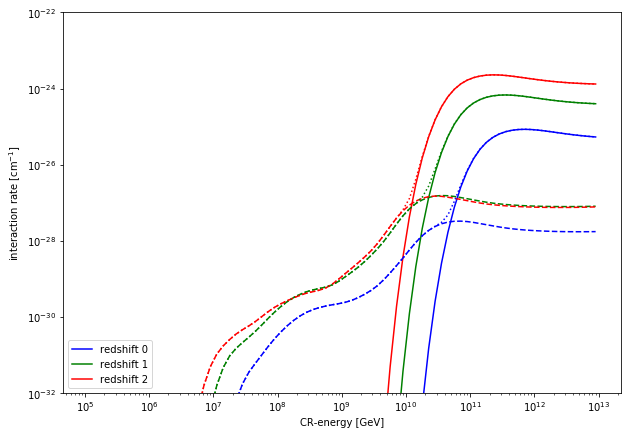

In [65]:
%%time
plt.figure(figsize = [10,7])

e = e_cosmicray.grid

#With CMB
n = get_interaction_rate_fast(CMB, 101, e, 0., e_photons)
n1 = get_interaction_rate_fast(CMB, 101, e, 1., e_photons)
n2 = get_interaction_rate_fast(CMB, 101, e, 2., e_photons)
plt.loglog(e,n, label = 'redshift 0', color = 'blue')
plt.loglog(e,n1, label = 'redshift 1', color = 'green')
plt.loglog(e,n2, label = 'redshift 2', color = 'red')

#With CIB
n = get_interaction_rate_fast(CIB, 101, e, 0., e_photons)
n1 = get_interaction_rate_fast(CIB, 101, e, 1., e_photons)
n2 = get_interaction_rate_fast(CIB, 101, e, 2., e_photons)
plt.loglog(e,n, linestyle = 'dashed', color = 'blue')
plt.loglog(e,n1, linestyle = 'dashed', color = 'green')
plt.loglog(e,n2, linestyle = 'dashed', color = 'red')

# With both combined
n = get_interaction_rate_fast(combined, 101, e, 0., e_photons)
n1 = get_interaction_rate_fast(combined, 101, e, 1., e_photons)
n2 = get_interaction_rate_fast(combined, 101, e, 2., e_photons)
plt.loglog(e,n, linestyle = 'dotted', color = 'blue')
plt.loglog(e,n1, linestyle = 'dotted', color = 'green')
plt.loglog(e,n2, linestyle = 'dotted', color = 'red')

plt.legend(loc = 'lower left')
plt.xlabel('CR-energy [GeV]')
plt.ylabel('interaction rate [cm$^{-1}$]')

plt.ylim([1e-32,1e-22])

In [66]:
%%timeit
#With CMB
n = get_interaction_rate_fast(CMB, 101, e, 0., e_photons)

100 loops, best of 3: 5.32 ms per loop


## Testing the accuracy depending on photon grid

(-1, 1)

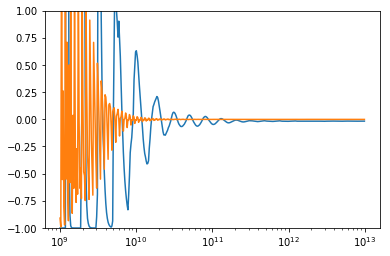

In [67]:
e_cosmicray = EnergyGrid(9,13,100)
e_photons_small = EnergyGrid(-20,-8,5)
e_photons_medium = EnergyGrid(-20,-8,20)
e_photons_large = EnergyGrid(-20,-8,400)

int_rate_small = get_interaction_rate_fast(CMB, 101, e_cosmicray.grid, 1., e_photons_small)
int_rate_medium = get_interaction_rate_fast(CMB, 101, e_cosmicray.grid, 1., e_photons_medium)
int_rate_large = get_interaction_rate_fast(CMB, 101, e_cosmicray.grid, 1., e_photons_large)

plt.semilogx(e_cosmicray.grid, (int_rate_small-int_rate_large) / int_rate_large)
plt.semilogx(e_cosmicray.grid, (int_rate_medium-int_rate_large) / int_rate_large)
plt.ylim([-1,1])

(1e-32, 1e-22)

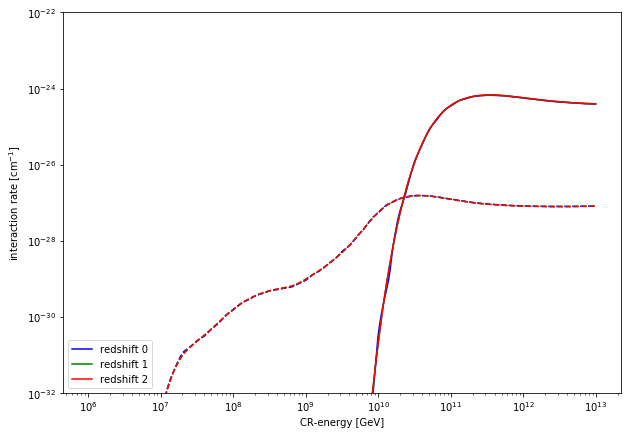

In [68]:
e_cosmicray = EnergyGrid(6,13,100)
e_photons_small = EnergyGrid(-20,-8,5)
e_photons_medium = EnergyGrid(-20,-8,20)
e_photons_large = EnergyGrid(-20,-8,400)

plt.figure(figsize = [10,7])

e = e_cosmicray.grid
n = get_interaction_rate_fast(CMB, 101, e, 1., e_photons_small)
n1 = get_interaction_rate_fast(CMB, 101, e, 1., e_photons_medium)
n2 = get_interaction_rate_fast(CMB, 101, e, 1., e_photons_large)
plt.loglog(e,n, label = 'redshift 0', color = 'blue')
plt.loglog(e,n1, label = 'redshift 1', color = 'green')
plt.loglog(e,n2, label = 'redshift 2', color = 'red')

n = get_interaction_rate_fast(CIB, 101, e, 1., e_photons_small)
n1 = get_interaction_rate_fast(CIB, 101, e, 1., e_photons_medium)
n2 = get_interaction_rate_fast(CIB, 101, e, 1., e_photons_large)
plt.loglog(e,n, linestyle = 'dashed', color = 'blue')
plt.loglog(e,n1, linestyle = 'dashed', color = 'green')
plt.loglog(e,n2, linestyle = 'dashed', color = 'red')

plt.legend(loc = 'lower left')
plt.xlabel('CR-energy [GeV]')
plt.ylabel('interaction rate [cm$^{-1}$]')

plt.ylim([1e-32,1e-22])

## Recreating Literature Plots as crosscheck

Figure 3 in private note on CR propagation

Shown is the Energy loss length, which is given by
$$
L_{\text{loss}} = - \frac{c E}{B} = c t_{\text{cool}} = \frac{c} {\sum_i \Gamma_i K_i}
$$

where $K_i$ is the fractional energy loss per interation, which I will estimate here as $K = 0.2$

### For Protons

/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in divide
  
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in divide
  if __name__ == '__main__':
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in divide
  # Remove the CWD from sys.path while we load stuff.
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in divid

(0.01, 10000000.0)

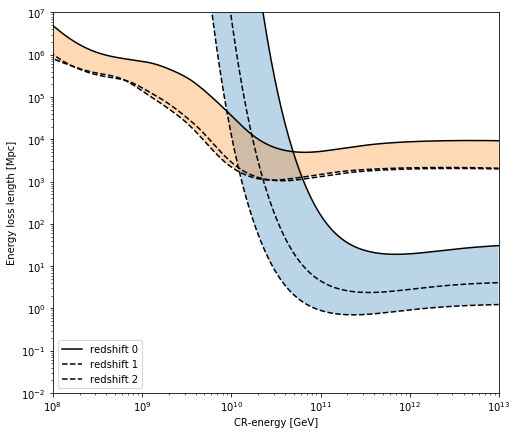

In [69]:
CmToMpC = 3.24078e-25
K = 0.2

plt.figure(figsize = [8,7])

e = e_cosmicray.grid

n = 1 / get_interaction_rate_fast(CMB, 101, e, 0., e_photons) / K * CmToMpC
n1 = 1 / get_interaction_rate_fast(CMB, 101, e, 1., e_photons) / K * CmToMpC
n2 = 1 / get_interaction_rate_fast(CMB, 101, e, 2., e_photons) / K * CmToMpC
plt.loglog(e, n, label = 'redshift 0', color = 'black', linewidth = 1.5)
plt.loglog(e, n1, label = 'redshift 1', color = 'black', linestyle = 'dashed', linewidth = 1.5)
plt.loglog(e, n2, label = 'redshift 2', color = 'black', linestyle = 'dashed', linewidth = 1.5)
plt.fill_between(e,n,n2, alpha = 0.3)


n = 1 / get_interaction_rate_fast(CIB, 101, e, 0., e_photons) / K * CmToMpC
n1 = 1 / get_interaction_rate_fast(CIB, 101, e, 1., e_photons) / K * CmToMpC
n2 = 1 / get_interaction_rate_fast(CIB, 101, e, 2., e_photons) / K * CmToMpC
plt.loglog(e, n, color = 'black', linewidth = 1.5)
plt.loglog(e, n1, color = 'black', linestyle = 'dashed', linewidth = 1.5)
plt.loglog(e, n2, color = 'black', linestyle = 'dashed', linewidth = 1.5)
plt.fill_between(e,n,n2, alpha = 0.3)


plt.legend(loc = 'lower left')
plt.xlabel('CR-energy [GeV]')
plt.ylabel('Energy loss length [Mpc]')

plt.xlim(1e8,1e13)
plt.ylim(1e-2,1e7)

### For Nitrogen and Iron

Compare to arXiv: 1508.01824, Figure 1

/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in divide
  
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in divide
  if __name__ == '__main__':
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in divide
  # Remove the CWD from sys.path while we load stuff.
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in divid

(0.01, 10000000.0)

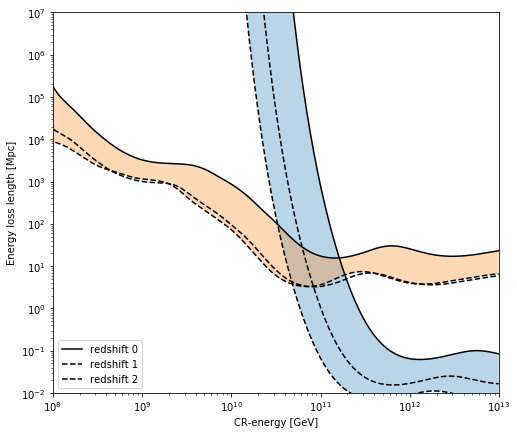

In [70]:
CmToMpC = 3.24078e-25
K = 0.2

plt.figure(figsize = [8,7])

e = e_cosmicray.grid

n = 1 / get_interaction_rate_fast(CMB, 5624, e, 0., e_photons) * CmToMpC
n1 = 1 / get_interaction_rate_fast(CMB, 5624, e, 1., e_photons) * CmToMpC * 2.
n2 = 1 / get_interaction_rate_fast(CMB, 5624, e, 2., e_photons) * CmToMpC * 3.
plt.loglog(e, n, label = 'redshift 0', color = 'black', linewidth = 1.5)
plt.loglog(e, n1, label = 'redshift 1', color = 'black', linestyle = 'dashed', linewidth = 1.5)
plt.loglog(e, n2, label = 'redshift 2', color = 'black', linestyle = 'dashed', linewidth = 1.5)
plt.fill_between(e,n,n2, alpha = 0.3)


n = 1 / get_interaction_rate_fast(CIB, 5624, e, 0., e_photons) * CmToMpC
n1 = 1 / get_interaction_rate_fast(CIB, 5624, e, 1., e_photons) * CmToMpC
n2 = 1 / get_interaction_rate_fast(CIB, 5624, e, 2., e_photons) * CmToMpC
plt.loglog(e, n, color = 'black', linewidth = 1.5)
plt.loglog(e, n1, color = 'black', linestyle = 'dashed', linewidth = 1.5)
plt.loglog(e, n2, color = 'black', linestyle = 'dashed', linewidth = 1.5)
plt.fill_between(e,n,n2, alpha = 0.3)


plt.legend(loc = 'lower left')
plt.xlabel('CR-energy [GeV]')
plt.ylabel('Energy loss length [Mpc]')

plt.xlim(1e8,1e13)
plt.ylim(1e-2,1e7)

/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in divide
  
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in divide
  if __name__ == '__main__':
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in divide
  app

(0.01, 10000.0)

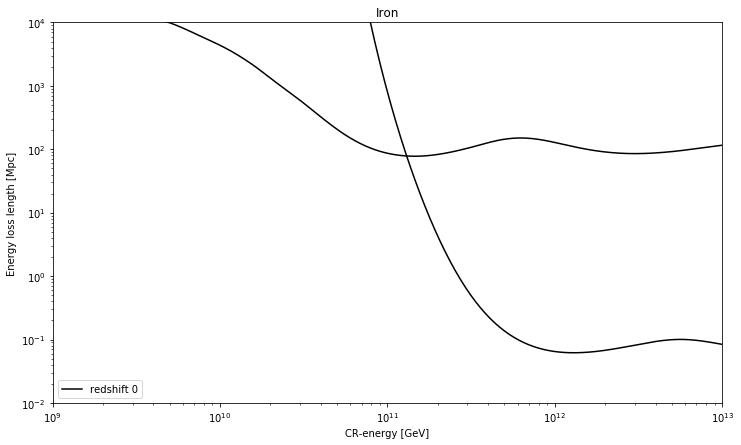

In [71]:
CmToMpC = 3.24078e-25
K = 0.2

plt.figure(figsize = [12,7])

e = e_cosmicray.grid

n = 1 / get_interaction_rate_fast(CMB, 5624, e, 0., e_photons) * CmToMpC
n2 = 1 / get_interaction_rate_fast(CMB, 5624, e, 2., e_photons) * CmToMpC
plt.loglog(e, n, label = 'redshift 0', color = 'black', linewidth = 1.5)
#plt.loglog(e, n2, label = 'redshift 2', color = 'black', linestyle = 'dashed', linewidth = 1.5)
#plt.fill_between(e,n,n2, alpha = 0.3)


n = 1 / get_interaction_rate_fast(CIB, 5624, e, 0., e_photons) / K * CmToMpC
n2 = 1 / get_interaction_rate_fast(CIB, 5624, e, 2., e_photons) / K * CmToMpC
plt.loglog(e, n, color = 'black', linewidth = 1.5)
#plt.loglog(e, n2, color = 'black', linestyle = 'dashed', linewidth = 1.5)
#plt.fill_between(e,n,n2, alpha = 0.3)


plt.legend(loc = 'lower left')
plt.xlabel('CR-energy [GeV]')
plt.ylabel('Energy loss length [Mpc]')
plt.title('Iron')

plt.xlim(1e9,1e13)
plt.ylim(1e-2,1e4)

/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in divide
  
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in divide
  if __name__ == '__main__':
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in divide
  # Remove the CWD from sys.path while we load stuff.
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in divid

(0.01, 10000000.0)

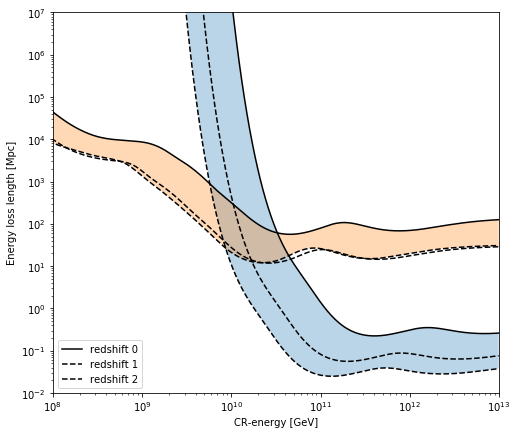

In [72]:
CmToMpC = 3.24078e-25
K = 0.2

plt.figure(figsize = [8,7])

e = e_cosmicray.grid

n = 1 / get_interaction_rate_fast(CMB, 1407, e, 0., e_photons) * CmToMpC
n1 = 1 / get_interaction_rate_fast(CMB, 1407, e, 1., e_photons) * CmToMpC * 2.
n2 = 1 / get_interaction_rate_fast(CMB, 1407, e, 2., e_photons) * CmToMpC * 3.
plt.loglog(e, n, label = 'redshift 0', color = 'black', linewidth = 1.5)
plt.loglog(e, n1, label = 'redshift 1', color = 'black', linestyle = 'dashed', linewidth = 1.5)
plt.loglog(e, n2, label = 'redshift 2', color = 'black', linestyle = 'dashed', linewidth = 1.5)
plt.fill_between(e,n,n2, alpha = 0.3)


n = 1 / get_interaction_rate_fast(CIB, 1407, e, 0., e_photons) * CmToMpC
n1 = 1 / get_interaction_rate_fast(CIB, 1407, e, 1., e_photons) * CmToMpC
n2 = 1 / get_interaction_rate_fast(CIB, 1407, e, 2., e_photons) * CmToMpC
plt.loglog(e, n, color = 'black', linewidth = 1.5)
plt.loglog(e, n1, color = 'black', linestyle = 'dashed', linewidth = 1.5)
plt.loglog(e, n2, color = 'black', linestyle = 'dashed', linewidth = 1.5)
plt.fill_between(e,n,n2, alpha = 0.3)


plt.legend(loc = 'lower left')
plt.xlabel('CR-energy [GeV]')
plt.ylabel('Energy loss length [Mpc]')

plt.xlim(1e8,1e13)
plt.ylim(1e-2,1e7)

In [73]:
ls

Cross sections.ipynb     CRP2_TALYS_nonel.dat     peanut_IAS_nonel.dat
CRP2_TALYS_egrid.dat     peanut_IAS_egrid.dat     Redistribution.ipynb
CRP2_TALYS_incl_i_j.dat  peanut_IAS_incl_i_j.dat  sophia_csec.dat


/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in divide
  import sys
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


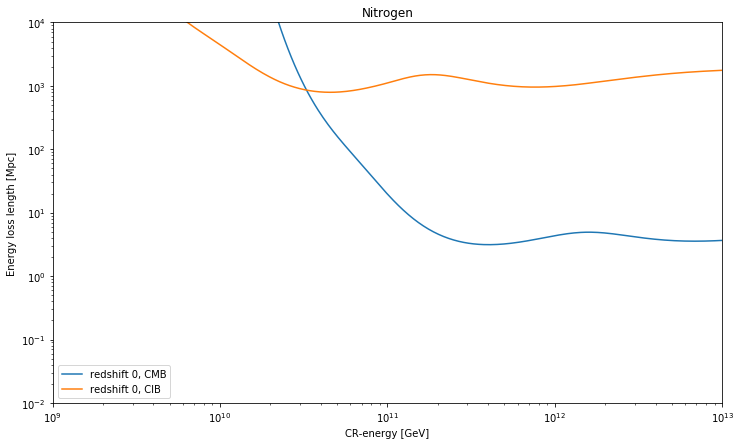

/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in divide
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in divide
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


(0.01, 10000.0)

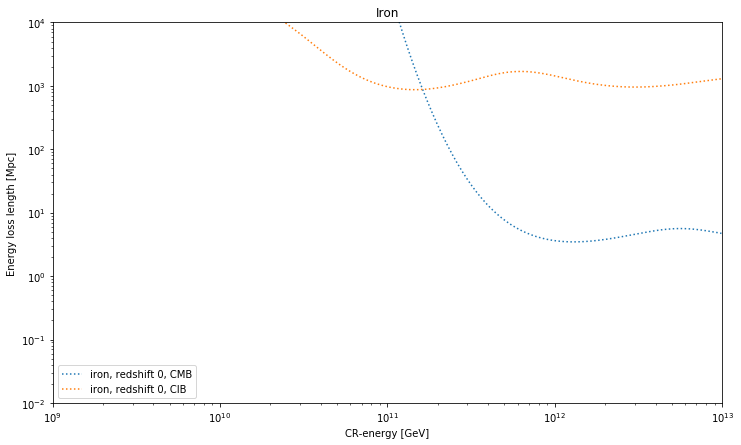

In [74]:
CmToMpC = 3.24078e-25

plt.figure(figsize = [12,7])

e = e_cosmicray.grid

n = 1 / get_interaction_rate_fast(CMB, 1407, e, 0., e_photons) * 14 * CmToMpC
plt.loglog(e, n, label = 'redshift 0, CMB', linewidth = 1.5)
n = 1 / get_interaction_rate_fast(CIB, 1407, e, 0., e_photons) * 14 * CmToMpC
plt.loglog(e, n, label = 'redshift 0, CIB', linewidth = 1.5)

plt.legend(loc = 'lower left')
plt.xlabel('CR-energy [GeV]')
plt.ylabel('Energy loss length [Mpc]')
plt.title('Nitrogen')

plt.xlim(1e9,1e13)
plt.ylim(1e-2,1e4)

plt.show()



plt.figure(figsize = [12,7])

e = e_cosmicray.grid

n = 1 / get_interaction_rate_fast(CMB, 5624, e, 0., e_photons) * CmToMpC * 56
plt.loglog(e, n, label = 'iron, redshift 0, CMB', linestyle = 'dotted', linewidth = 1.5)
n = 1 / get_interaction_rate_fast(CIB, 5624, e, 0., e_photons) * CmToMpC * 56
plt.loglog(e, n, label = 'iron, redshift 0, CIB', linestyle = 'dotted', linewidth = 1.5)

plt.legend(loc = 'lower left')
plt.xlabel('CR-energy [GeV]')
plt.ylabel('Energy loss length [Mpc]')
plt.title('Iron')

plt.xlim(1e9,1e13)
plt.ylim(1e-2,1e4)

/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in divide
  
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in divide
  # Remove the CWD from sys.path while we load stuff.
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in divide
  del sys.path[0]
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in divide
  del sys.path[0]
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in divide
  from ipyke

(0.01, 10000.0)

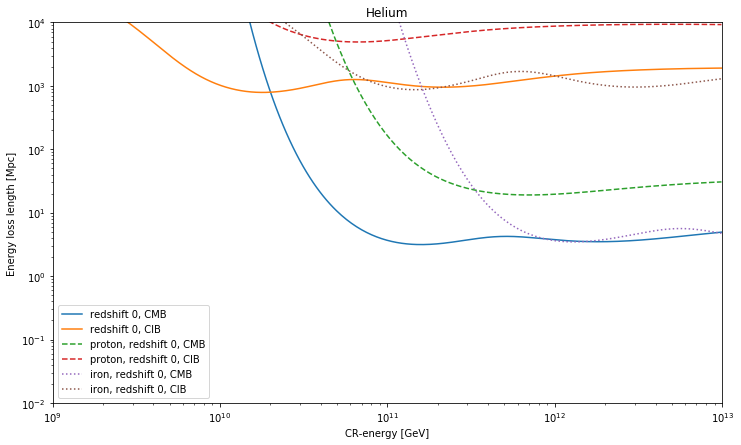

In [75]:
CmToMpC = 3.24078e-25
K = 0.2

plt.figure(figsize = [12,7])

e = e_cosmicray.grid

n = 1 / get_interaction_rate_fast(CMB, 402, e, 0., e_photons) * CmToMpC * 4.
plt.loglog(e, n, label = 'redshift 0, CMB', linewidth = 1.5)
n = 1 / get_interaction_rate_fast(CIB, 402, e, 0., e_photons) * CmToMpC * 4.
plt.loglog(e, n, label = 'redshift 0, CIB', linewidth = 1.5)

n = 1 / get_interaction_rate_fast(CMB, 101, e, 0., e_photons) * CmToMpC / 0.2
plt.loglog(e, n, label = 'proton, redshift 0, CMB', linestyle = 'dashed', linewidth = 1.5)
n = 1 / get_interaction_rate_fast(CIB, 101, e, 0., e_photons) * CmToMpC / 0.2
plt.loglog(e, n, label = 'proton, redshift 0, CIB', linestyle = 'dashed', linewidth = 1.5)

n = 1 / get_interaction_rate_fast(CMB, 5624, e, 0., e_photons) * CmToMpC * 56
plt.loglog(e, n, label = 'iron, redshift 0, CMB', linestyle = 'dotted', linewidth = 1.5)
n = 1 / get_interaction_rate_fast(CIB, 5624, e, 0., e_photons) * CmToMpC * 56
plt.loglog(e, n, label = 'iron, redshift 0, CIB', linestyle = 'dotted', linewidth = 1.5)


plt.legend(loc = 'lower left')
plt.xlabel('CR-energy [GeV]')
plt.ylabel('Energy loss length [Mpc]')
plt.title('Helium')

plt.xlim(1e9,1e13)
plt.ylim(1e-2,1e4)

# Cross section at high energy for SOPHIA

For the high energy behavior of the cross section we use a simple parameterization as in given astro-ph/9903478 eq. (17)

The formula for protons (neutrons) reads:
$$
\sigma_\text{frag}(\epsilon^\prime) = \left[ 1 - \exp \left( - \frac{\epsilon^\prime - 0.85}{0.69} \right) \right]
 [ 28.8 (26.0) (\epsilon^\prime)^{-0.34} + 58.3 (\epsilon^\prime)^{-0.34}]
$$

here $\epsilon^\prime$ deontes the proton energy in the NRF

In [82]:
def cross_sec_proton_highE(e): # input in GeV
    fac1 = 1 - np.exp(-(e-0.85) / 0.69)
    fac2 = 28.8 * e**-0.34 + 59.3 * e**0.095
    return fac1 * fac2 * 1e-3 

def cross_sec_proton_highE2(e): # input in GeV
    Q = (e - 0.51)/0.1
    Q[Q < 0.] = 0.
    Q[Q > 1.] = 1.
        
    fac2 = 80.3 * e**-0.34
    return fac2 * 1e-3 * Q


def cross_sec_neutron_highE(e): # input in GeV
    fac1 = 1 - np.exp(-(e-0.85) / 0.69)
    fac2 = 26.0 * e**-0.34 + 59.3 * e**0.095
    return fac1 * fac2 * 1e-3

def cross_sec_neutron_highE2(e): # input in GeV
    Q = (e - 0.51)/0.1
    Q[Q < 0.] = 0.
    Q[Q > 1.] = 1.
        
    fac2 = 60.2 * e**-0.34
    return fac2 * 1e-3 * Q

In [83]:
def Qfunc(e):
    Q = (e - 0.51)/0.1
    Q[Q < 0.] = 0.
    Q[Q > 1.] = 1.
    
    return Q

## comparing the directly extracted data

In [76]:
import os
s_cs = np.loadtxt('sophia_csec.dat',delimiter=',') 

In [77]:
s_cs[:,0]

array([1.00000000e-02, 1.01391839e-02, 1.02803051e-02, ...,
       9.72733778e+09, 9.86272669e+09, 1.00000000e+10])

In [78]:
m_proton = 0.939

/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


(0.001, 1)

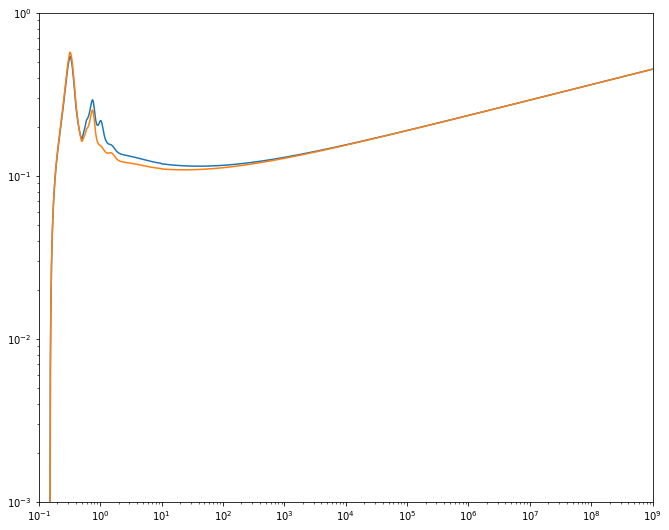

In [79]:
plt.figure(figsize=(11,9))

energy = s_cs[:,0]
#s = m_proton * energy

csec_proton = 1e-3*s_cs[:,1]
csec_neutron = 1e-3*s_cs[:,2]

plt.semilogx(energy, csec_proton)
plt.semilogx(energy, csec_neutron)

plt.semilogx(energy, cross_sec_proton_highE(energy) + cross_sec_proton_highE2(energy))
plt.semilogx(energy, cross_sec_neutron_highE(energy) + cross_sec_neutron_highE2(energy))
#plt.semilogx(energy, cross_sec_neutron_highE(energy))

plt.yscale('log')

plt.xlim(1e-1,1e9)
plt.ylim(0.,0.6)
plt.ylim(1e-3,1)

(0.0, 0.6)

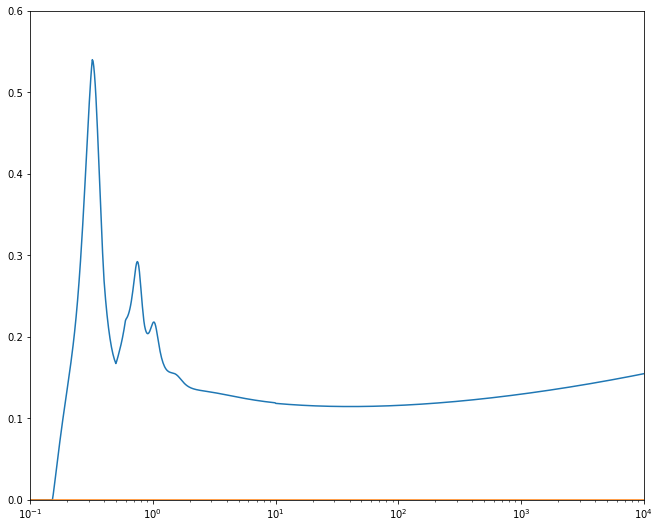

In [80]:
plt.figure(figsize=(11,9))

energy = s_cs[:,0]
#s = m_proton * energy

csec_proton = 1e-3*s_cs[:,1]
csec_neutron = 1e-3*s_cs[:,2]

plt.semilogx(energy, csec_proton)

plt.semilogx(energy, cross_sec_proton_highE(energy))
#plt.semilogx(energy, cross_sec_neutron_highE(energy))

plt.xlim(1e-1,1e4)
plt.ylim(0.,0.6)
#plt.ylim(1e-3,1)